# 01 - Data Preprocessing

## A - Libraries

In [1]:
from metaboDGD.util import data, train
from metaboDGD.src import model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.distributions as D
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## B - Retrieving Separate Datasets

In [2]:
df, cohorts = data.combine_cohort_datasets()

In [3]:
# Convert the df to a numpy array of dim (# samples, # metabolites)
df_rows = list(df.T.index)
df_cols = list(df.T.columns)
np_df = df.T.to_numpy()

# Get cells that have a 0.0
np_df_zm = (np_df == 0)

# Exponentiate the df by 2
np_exp = np.exp2(np_df)

# Retain the 0.0 values
np_exp[np_df_zm] = 0.0

# Recreate the exponent version of the dataframe
df_exp = pd.DataFrame(np_exp, index=df_rows, columns=df_cols)

In [4]:
## TODO: Transfer to 02-Training
class MetaboliteDataset(Dataset):
    def __init__(self, np_mat):
        # Instantiate Dataset object
        # Initialize Directory containing data, annotations, transforms
        self.metabolite_abundances = np_mat
        # self.metabolite_abundances = self.metabolite_abundances.to(torch.float32)
        self.n_metabolites = self.metabolite_abundances.shape[1]

    def __len__(self):
        return self.metabolite_abundances.shape[0]

    def __getitem__(self, idx):
        return self.metabolite_abundances[idx], idx


train_dict = {}
test_dict  = {}

# Split each cohort to train and test
for c in cohorts.keys():
    # Get Sample IDs for training and testing
    _train, _test = train_test_split(cohorts[c]['sample_list'],
                     train_size=0.8,
                     random_state=100)
    train_dict[c] = df_exp.loc[_train].to_numpy()
    test_dict[c]  = df_exp.loc[_test].to_numpy()


# Combine the dataframes together
train_df = np.vstack(list(train_dict.values()))
test_df  = np.vstack(list(test_dict.values()))

from torch.utils.data import Dataset, DataLoader
train_dataset = MetaboliteDataset(train_df)
test_dataset = MetaboliteDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

dgd_model = model.MetaboDGD(
    latent_dim=20,
    output_dim=1915,
    dec_hidden_layers_dim=[500, 1000, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=8,
    cm_type='diagonal'
)

dgd_model, train_rep, test_rep, history = train.train_dgd(
    dgd_model=dgd_model,
    train_loader=train_loader,
    validation_loader=test_loader,
    n_epochs=100,
)

_______________________________
MIN A: 1.0
MIN X: tensor([1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05])
MIN Y: tensor([0.6599, 0.6599, 0.6599, 0.6599, 0.6599, 0.6599, 0.6599, 0.6599, 0.6599,
        0.6599, 0.6599, 0.6599, 0.6599, 0.6599, 0.6599, 0.6599],
       grad_fn=<MinBackward0>)
_______________________________
ZER TERM: tensor([[0.6929, 0.6904, 0.7135,  ..., 0.6816, 0.6981, 0.7044],
        [0.6929, 0.6904, 0.7135,  ..., 0.6816, 0.6981, 0.7044],
        [0.6929, 0.6904, 0.7135,  ..., 0.6816, 0.6981, 0.7044],
        ...,
        [0.6929, 0.6904, 0.7135,  ..., 0.6816, 0.6981, 0.7044],
        [0.6929, 0.6904, 0.7135,  ..., 0.6816, 0.6981, 0.7044],
        [0.6929, 0.6904, 0.7135,  ..., 0.6816, 0.6981, 0.7044]],
       dtype=torch.float64, grad_fn=<ExpBackward0>)
LOSS_MIN X: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### OTHER CODE

In [5]:
history

train_loss      val_loss  train_recon_loss  val_recon_loss  \
0   8.366690e+06  8.146533e+06      8.366691e+06    8.146534e+06   
1   8.347009e+06  8.127363e+06      8.347010e+06    8.127364e+06   
2   8.327254e+06  8.108452e+06      8.327255e+06    8.108453e+06   
3   8.307680e+06  8.089498e+06      8.307681e+06    8.089499e+06   
4   8.288076e+06  8.070472e+06      8.288077e+06    8.070473e+06   
..           ...           ...               ...             ...   
95  2.858303e+06  2.759334e+06      2.858304e+06    2.759335e+06   
96  2.794954e+06  2.698358e+06      2.794955e+06    2.698359e+06   
97  2.732776e+06  2.638524e+06      2.732777e+06    2.638525e+06   
98  2.671780e+06  2.579829e+06      2.671781e+06    2.579830e+06   
99  2.611962e+06  2.522287e+06      2.611963e+06    2.522288e+06   

    train_dist_loss  val_dist_loss  epoch  
0       -104.013355    -104.036381      1  
1       -104.055469    -104.078512      2  
2       -104.097633    -104.120663      3  
3       -104.139806    -104.162814      4  
4       -104.182006    -104.204994      5  
..              ...            ...    ...  
95      -108.100749    -108.123177     96  
96      -108.144680    -108.167126     97  
97      -108.188624    -108.211088     98  
98      -108.232589    -108.255061     99  
99      -108.276572    -108.299044    100  

[100 rows x 7 columns]

Text(0.5, 1.0, 'Training Loss Curve - Total')

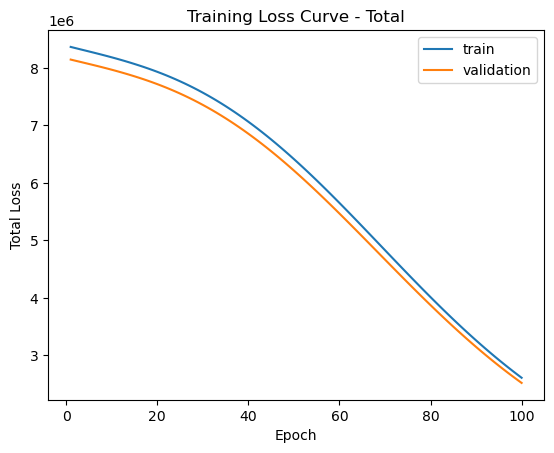

In [17]:
plt.plot(history['epoch'], history['train_loss'], label='train')
plt.plot(history['epoch'], history['val_loss']  , label='validation')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Loss Curve - Total")

Text(0.5, 1.0, 'Training Loss Curve - Reconstruction')

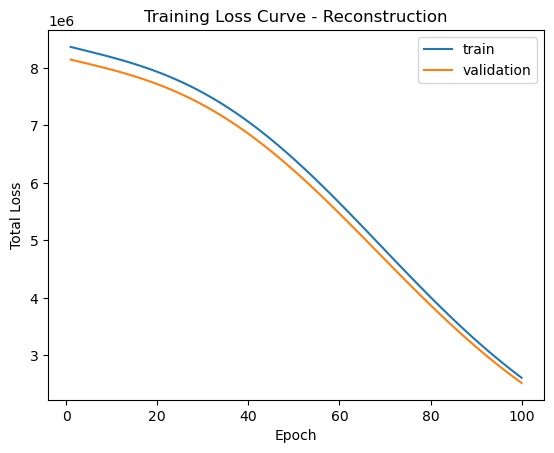

In [18]:
plt.plot(history['epoch'], history['train_recon_loss'], label='train')
plt.plot(history['epoch'], history['val_recon_loss']  , label='validation')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Loss Curve - Reconstruction")

Text(0.5, 1.0, 'Training Loss Curve - Reconstruction')

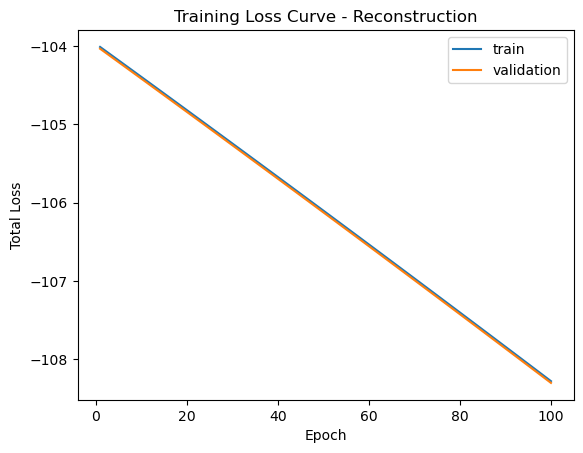

In [19]:
plt.plot(history['epoch'], history['train_dist_loss'], label='train')
plt.plot(history['epoch'], history['val_dist_loss']  , label='validation')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Loss Curve - Reconstruction")

In [ ]:
dgd_model.dec.normal_layer.pi.min()

In [ ]:
torch.log(torch.Tensor([-1]))

In [ ]:
sample = np_df[0]
zero_mask = (sample == 0)
nonzero_mask = ~(zero_mask)

In [ ]:
torch.zeros_like(torch.randn((10,10))).dtype

In [ ]:
# test = torch.rand((10,))
# # test[5] = 0.0
# # test[~(test == 0)] = 999.99
# # test
# torch.zeros_like(test)
# torch.exp(gamma_dist.log_prob(torch.full(fill_value=1e-5, size=(1,10))))

gamma_dist = D.Gamma(torch.full(fill_value=10.0, size=(1,)),
                     torch.full(fill_value=0.25, size=(1,)))
plt.hist(gamma_dist.sample(sample_shape=(50000,)).squeeze().numpy(), bins=300)
plt.xlim(left=0, right=100)
plt.show()

In [ ]:
torch.split(torch.Tensor(np_df), 32)

In [ ]:
np.count(np_exp.var(axis=0) > np_exp.mean(axis=0))

In [ ]:
## DO NOT REMOVE
zero_counts = np.count_nonzero(np_exp == 0, axis=0)
plt.scatter(x=np_exp.mean(axis=0),
            y=np_exp.var(axis=0),
            c=zero_counts,
            cmap='viridis',
            marker='o',
            alpha=0.5)
plt.xlabel("Mean Metabolite Abundance (Log 2 Scale)")
plt.ylabel("Variance Metabolite Abundance (Log 2 Scale)")
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.colorbar(label='Number of Zeroes')
plt.title("Mean-Variance Plot")

In [ ]:
type(np_df == 0)

In [ ]:
## DO NOT REMOVE
plt.hist(
    np_exp[:,100],
)
plt.title("Histogram of Processed Metabolite Abundances")
plt.show()

In [ ]:
# BRCA1 ccRCC3  ccRCC4  COAD    GBM HurthleCC   PDAC    PRAD
target_cohort = "BRCA1"
START_IDX = len(cohorts["ccRCC3"]['sample_list']) * 0
END_IDX = len(cohorts[target_cohort]['sample_list'])
cohort_df = np_df[START_IDX:START_IDX+END_IDX]
zero_counts = np.count_nonzero(cohort_df == 0, axis=0)

plt.scatter(x=cohort_df.mean(axis=0),
            y=cohort_df.var(axis=0),
            c=zero_counts,
            cmap='viridis',
            marker='o',
            alpha=0.3)
plt.xlabel("Mean Metabolite Abundance (Log 2)")
plt.ylabel("Variance Metabolite Abundance (Log 2)")
plt.title(target_cohort)
plt.colorbar(label='Number of Zeroes')

In [ ]:
# Gets the indices of the 26 metabolites present across all samples (26)
# set([x for x in range(0,1915)]) - set(np.unique(np.where(np_df == 0)[1]))

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
np_df = df.T.to_numpy()
pca_model = PCA(n_components=2)
results = pca_model.fit_transform(np_df)

plt.scatter(results[0:47,0], results[0:47, 1], c='red'          ,label="BRCA1")
plt.scatter(results[47:86,0], results[47:86, 1], c='orange'     ,label="COAD")
plt.scatter(results[86:133,0], results[86:133, 1], c='yellow'   ,label="ccRCC3")
plt.scatter(results[133:157,0], results[133:157, 1], c='green'  ,label="ccRCC4")
plt.scatter(results[157:163,0], results[157:163, 1], c='blue'   ,label="GBM")
plt.scatter(results[163:166,0], results[163:166, 1], c='purple' ,label="HurthleCC")
plt.scatter(results[166:178,0], results[166:178, 1], c='pink'   ,label="PDAC")
plt.scatter(results[178:224,0], results[178:224, 1], c='black'  ,label="PRAD")
plt.legend()
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=8)
gmm = gmm.fit(np_df)

In [ ]:
results = gmm.sample(n_samples=1000)

In [ ]:
import pandas as pd
pd.Series(results[1]).value_counts()

In [ ]:
pca_new = PCA(n_components=2)
results_new = pca_model.transform(results[0])
# results_new = pca_model.transform(results[0])
# plt.scatter(results_new[0:224,0]   , results_new[0:224, 1], c='red'          ,label="BRCA1")
# plt.scatter(results_new[224:426,0]  , results_new[224:426, 1], c='orange'     ,label="COAD")
# plt.scatter(results_new[426:609,0] , results_new[426:609, 1], c='yellow'   ,label="ccRCC3")
# plt.scatter(results_new[609:785,0], results_new[609:785, 1], c='green'  ,label="ccRCC4")
# plt.scatter(results_new[785:903,0], results_new[785:903, 1], c='blue'   ,label="GBM")
# plt.scatter(results_new[903:956,0], results_new[903:956, 1], c='purple' ,label="HurthleCC")
# plt.scatter(results_new[956:983,0], results_new[956:983, 1], c='pink'   ,label="PDAC")
plt.scatter(results_new[983:1000,0], results_new[983:1000, 1], c='black'  ,label="PRAD")
plt.legend()
plt.show()

In [ ]:
# pca_new = PCA(n_components=2)
results_new = pca_model.transform(results[0])
# plt.scatter(results_new[0:47,0]   , results_new[0:47, 1], c='red'          ,label="BRCA1")
# plt.scatter(results_new[47:86,0]  , results_new[47:86, 1], c='orange'     ,label="COAD")
# plt.scatter(results_new[86:133,0] , results_new[86:133, 1], c='yellow'   ,label="ccRCC3")
# plt.scatter(results_new[133:157,0], results_new[133:157, 1], c='green'  ,label="ccRCC4")
# plt.scatter(results_new[157:163,0], results_new[157:163, 1], c='blue'   ,label="GBM")
# plt.scatter(results_new[163:166,0], results_new[163:166, 1], c='purple' ,label="HurthleCC")
# plt.scatter(results_new[166:178,0], results_new[166:178, 1], c='pink'   ,label="PDAC")
# plt.scatter(results_new[178:224,0], results_new[178:224, 1], c='black'  ,label="PRAD")
plt.legend()
plt.show()

In [ ]:
# Get the xls file
cohort_name = "PRAD"
xls = pd.ExcelFile(f'data/PreprocessedData_{cohort_name}.xlsx')

# Get the dataframes for the preprocessed metabolomics data
# t = xls.parse("metabo_imputed_filtered_Tumor")
n = xls.parse("metabo_imputed_filtered_Normal")

# Replace IDs of the dataframes
# t.rename({"Unnamed: 0": "t_met"}, inplace=True, axis=1)
n.rename({"Unnamed: 0": "n_met"}, inplace=True, axis=1)

# Get list of metabolites
# t_list = t["t_met"].to_list()
n_list = n["n_met"].to_list()
# met_list = list(set(t_list) | set(n_list))

# Create a dictionary of the metabolite names and HMDB IDs
###########
# 05/25/25 - Eliminated HMDB IDs use because only 72% of the features have HMDB IDs across all cohorts
# For Reference:
#           TOTAL_FEATURES  TOTAL_FEATURES_WITH_HMDB_IDS
# BRCA1     324             215
# COAD      160	            141
# ccRCC3    727	            551
# ccRCC4    951	            701
# GBM       704	            357
# HurthleCC 668	            523
# PDAC      325	            279
# PRAD      382	            320
###########
# metanno = xls.parse("metanno")
# metanno_dict = metanno.set_index("H_name")["H_HMDB"].to_dict()
# hmdb_list = set(metanno.loc[metanno["H_name"].isin(n_list)]["H_HMDB"].tolist()


# Get dataframe with only sorted shared metabolites
# t_shared = t[t["t_met"].isin(met_list)]
# t_shared.sort_values("t_met", ignore_index=True, inplace=True)
# n_shared = n[n["n_met"].isin(met_list)]
# n_shared.sort_values("n_met", ignore_index=True, inplace=True)
# merged = pd.concat([t_shared, n_shared], axis=1)

# n = n.set_index(n["n_met"])
n_no_labels = n.drop(labels=['n_met'], axis=1)
print(n.set_index("n_met"))